<a href="https://colab.research.google.com/github/Tavo826/Aprende-ML-Book-/blob/main/Datos_Desbalanceados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se utiliza una base de datos de fraude de tarjeta de crédito

Consta de 285.000 filas con 31 características

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

rcParams['figure.figsize'] = 14, 8.7
LABELS = ["Normal","Fraud"]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Libro_AprendeML/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(df.shape)
print('Clases:')
print(pd.value_counts(df['Class'], sort=True))

print('\nLos casos de fraude representan el 0,17% de las muestras')

(284807, 31)
Clases:
0    284315
1       492
Name: Class, dtype: int64

Los casos de fraude representan el 0,17% de las muestras


Text(0, 0.5, 'Number of observations')

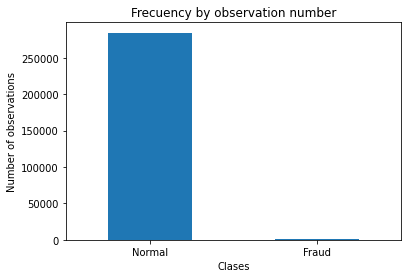

In [ ]:
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('Frecuency by observation number')
plt.xlabel('Clases')
plt.ylabel('Number of observations')

### Estrategias para el manejo de datos desbalanceados:

**1. Ajuste de parámetros del modelo:**

Se intenta equilibrar la clase minoritaria penalizando la clase mayoritaria. 

Con el LogisticRegression se puede utilizar el parámetro *class_weight = balanced*.

En redes neuronales se puede ajustar la métrica de Loss para que penalice a las clases mayoritarias.

**2. Modificar el dataset:**

Se pueden eliminar muestras de la clase mayoritaria para intentar equilibrar el dataset. Esto puede generar que se eliminen muestras con información importante, por lo tanto se debe tener algún *criterio* si se desea borrar información.

Se puede agregar nuevas filas con los mismos valores de la clase minoritaria, pero el modelo podría sobreajustarse.

**3. Muestras artificiales:**

Se puede intentar generar muestrar sintéticas (no idénticas) utilizando diferentes algoritmos. Es peligroso porque se puede alterar la distribución de la clase y alterar la clasificación del modelo.

**4. Balanced ensembled methods:**

Entrena diversos modelos y entre todos se obtiene el resultado final, todo esto tomando muestras equilibradas

## Regressión Logística desequilibrada

In [ ]:
y = df['Class']
X = df.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

def run_model(X_train, X_test, y_train, y_test):
  clf_base = LogisticRegression(C=1.0, 
                                penalty='l2',
                                random_state=1,
                                solver='newton-cg')
  clf_base.fit(X_train, y_train)
  return clf_base

model = run_model(X_train, X_test, y_train, y_test)

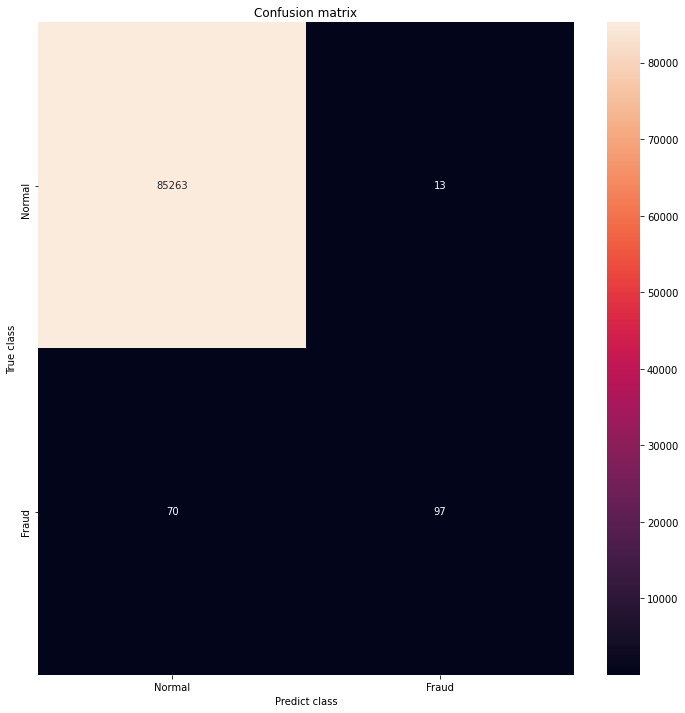

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85276
           1       0.88      0.58      0.70       167

    accuracy                           1.00     85443
   macro avg       0.94      0.79      0.85     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
def mostrar_resultados(y_test, pred_y):
  conf_matrix = confusion_matrix(y_test, pred_y)
  plt.figure(figsize=(12,12))
  sns.heatmap(conf_matrix,
              xticklabels=LABELS, 
              yticklabels=LABELS, 
              annot=True,
              fmt='d')
  plt.title('Confusion matrix')
  plt.ylabel('True class')
  plt.xlabel('Predict class')
  plt.show()
  print(classification_report(y_test, pred_y))

pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Estrategias

## 1. Penalización para compensar

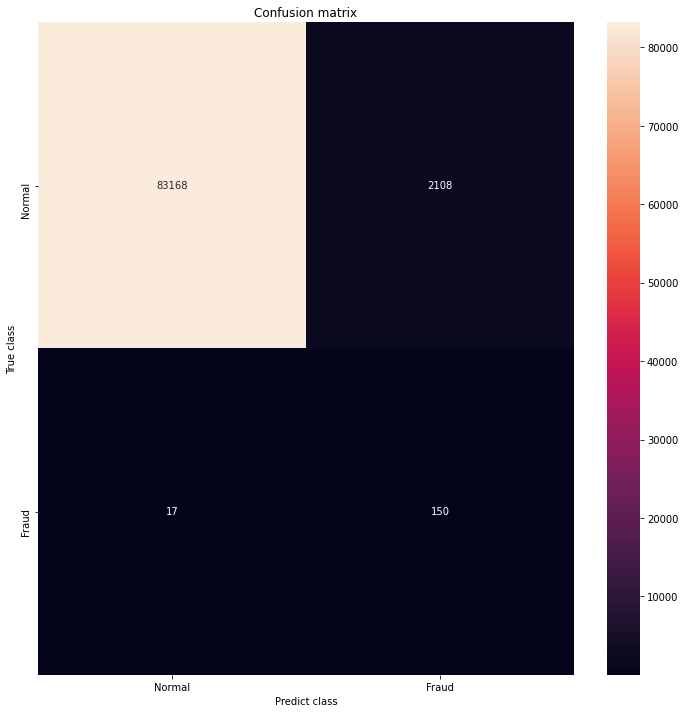

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85276
           1       0.07      0.90      0.12       167

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [ ]:
def run_model_balanced(X_train, X_test, y_train, y_test):
  clf = LogisticRegression(C=1.0,
                           penalty='l2',
                           random_state=1,
                           solver='newton-cg',
                           class_weight='balanced')
  clf.fit(X_train, y_train)
  return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

## 2. Subsampling en la clase mayoritaria

Distribución antes del resampling Counter({0: 199039, 1: 325})
Distribución después del resampling Counter({0: 650, 1: 325})


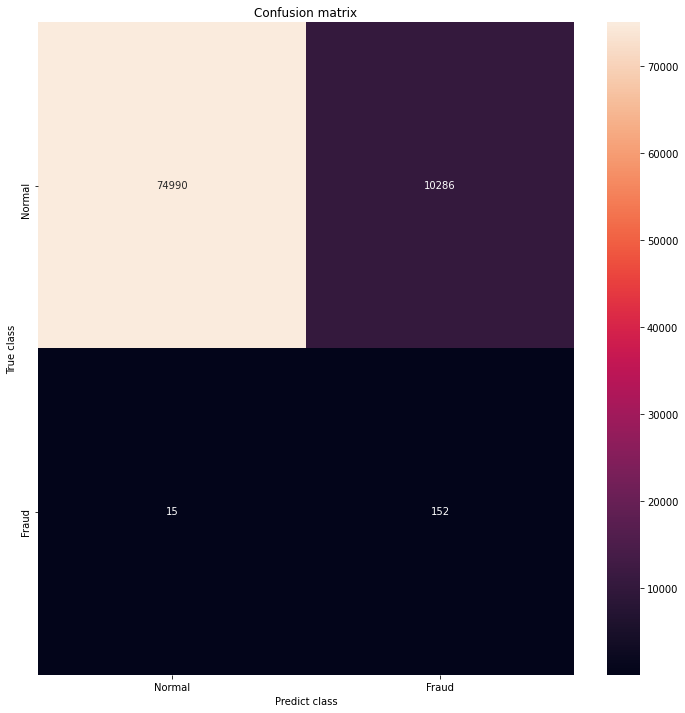

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     85276
           1       0.01      0.91      0.03       167

    accuracy                           0.88     85443
   macro avg       0.51      0.89      0.48     85443
weighted avg       1.00      0.88      0.93     85443



In [ ]:
us = NearMiss(ratio=0.5,
              n_neighbors=3,
              version=2,
              random_state=1)

X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print('Distribución antes del resampling {}'.format(Counter(y_train)))
print('Distribución después del resampling {}'.format(Counter(y_train_res)))

model = run_model(X_train_res, X_test, y_train_res, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

## 3. Oversampling de la clase minoritaria

Dist_test, y_train_res, y_ribución antes del resampling Counter({0: 199039, 1: 325})
Distribución después del resampling Counter({0: 199039, 1: 99519})


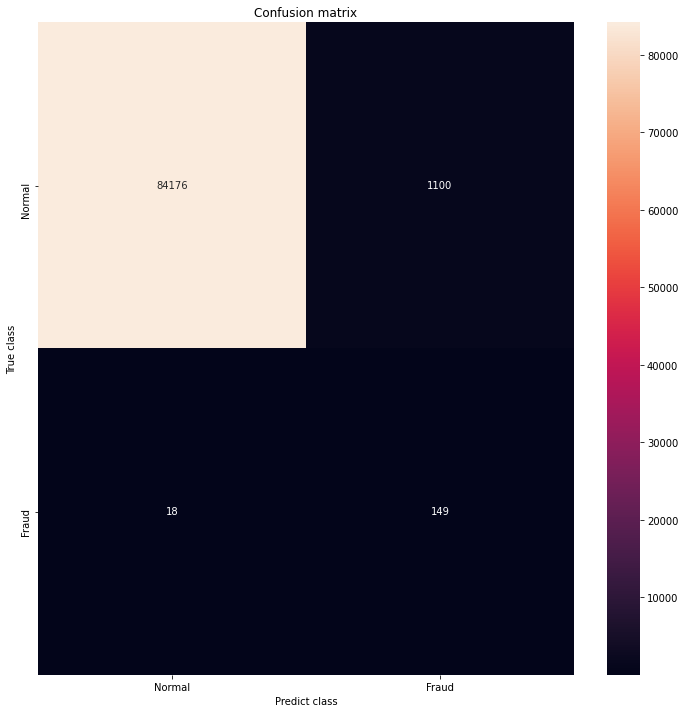

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85276
           1       0.12      0.89      0.21       167

    accuracy                           0.99     85443
   macro avg       0.56      0.94      0.60     85443
weighted avg       1.00      0.99      0.99     85443



In [ ]:
os = RandomOverSampler(ratio=0.5)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

print('Dist_test, y_train_res, y_ribución antes del resampling {}'.format(Counter(y_train)))
print('Distribución después del resampling {}'.format(Counter(y_train_res)))

model =run_model(X_train_res, X_test, y_train_res, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

## Plus. Combinando resampling con Smote-Tomek

Aplica en simultpaneo un algoritmo de subsampling y otro de oversampling a la vez

Dist_test, y_train_res, y_ribución antes del resampling Counter({0: 199039, 1: 325})
Distribución después del resampling Counter({0: 198212, 1: 98692})


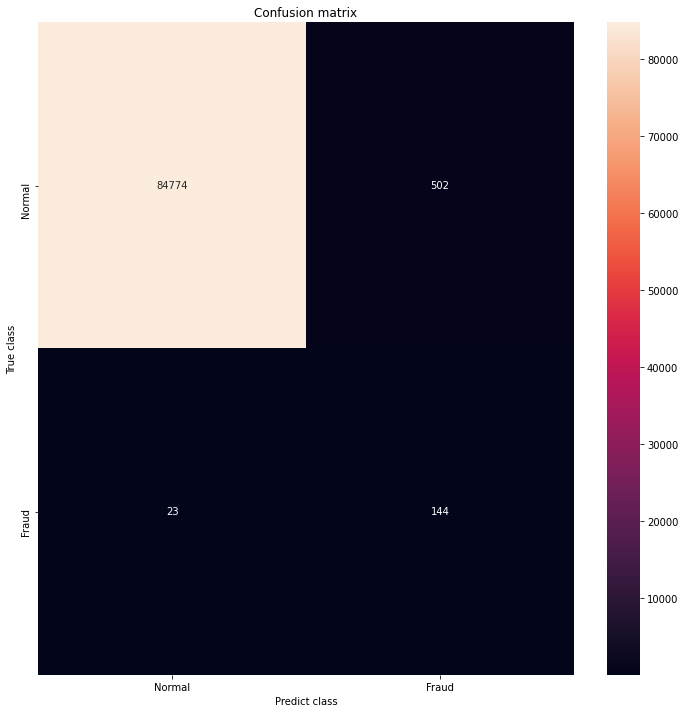

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85276
           1       0.22      0.86      0.35       167

    accuracy                           0.99     85443
   macro avg       0.61      0.93      0.68     85443
weighted avg       1.00      0.99      1.00     85443



In [ ]:
os_us = SMOTETomek(ratio=0.5)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

print('Dist_test, y_train_res, y_ribución antes del resampling {}'.format(Counter(y_train)))
print('Distribución después del resampling {}'.format(Counter(y_train_res)))

model =run_model(X_train_res, X_test, y_train_res, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

## 4. Ensamble de modelos con balanceo

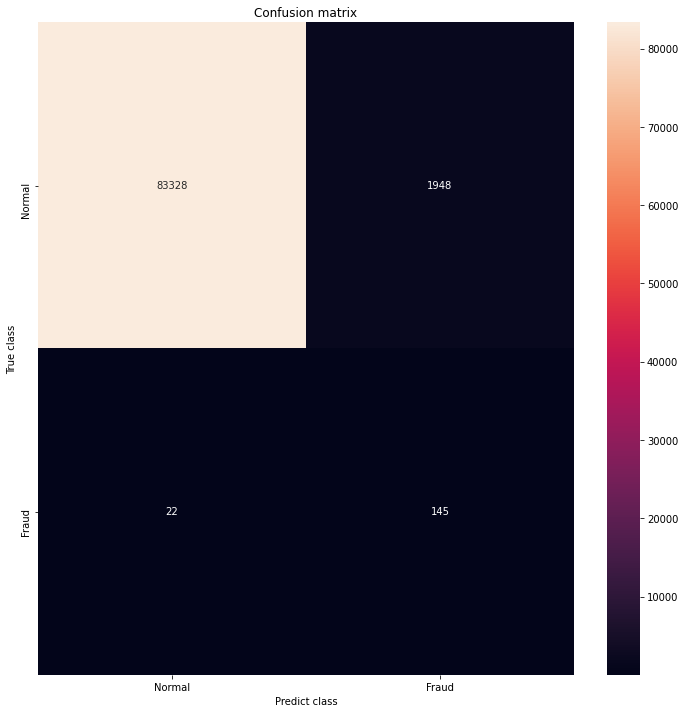

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85276
           1       0.07      0.87      0.13       167

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [ ]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

bbc.fit(X_train, y_train)
pred_y = bbc.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Resultados de las estrategias

In [ ]:
df = pd.DataFrame({'algorithm': ['Regresión Logística', 
                                 'Penalización',
                                 'NearMiss Subsampling',
                                 'Random Oversampling',
                                 'Smote Tomek',
                                 'Ensemble'],
                   'precision': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                   'recall': [0.58, 0.90, 0.91, 0.89, 0.86, 0.87]})

df['overall'] = df.apply(lambda row: (row.precision + row.recall)/2, 
                         axis=1)

df = df.sort_values(['overall'], ascending=False)
df

,algorithm,precision,recall,overall
2,NearMiss Subsampling,1.0,0.91,0.955
1,Penalización,1.0,0.90,0.950
3,Random Oversampling,1.0,0.89,0.945
5,Ensemble,1.0,0.87,0.935
4,Smote Tomek,1.0,0.86,0.930
0,Regresión Logística,1.0,0.58,0.790
